# Age Classification of Faces

In [ ]:
# Imports
# Please refer to requirements.txt for a full list of all libraries and their versions used in this project.

import numpy as np
import cv2
import os
from tensorflow.keras.models import load_model
import time
from datetime import datetime

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Setup

In [ ]:
# Loading the trained CNN model for age classification, and
# defining a list of age-ranges as defined in the model.

model = load_model("/content/drive/MyDrive/datasets/age_detect_cnn_model.h5")
age_ranges = ['1-2', '3-9', '10-20', '21-27', '28-45', '46-65', '66-116']

In [ ]:
# Importing the Haar Cascades classifier XML file.

face_cascade = cv2.CascadeClassifier("/content/drive/MyDrive/datasets/haarcascade_frontalface_default.xml")

In [ ]:
# Defining a function to shrink the detected face region by a scale for better prediction in the model.

def shrink_face_roi(x, y, w, h, scale=0.9):
    wh_multiplier = (1-scale)/2
    x_new = int(x + (w * wh_multiplier))
    y_new = int(y + (h * wh_multiplier))
    w_new = int(w * scale)
    h_new = int(h * scale)
    return (x_new, y_new, w_new, h_new)

In [ ]:
# Defining a function to create the predicted age overlay on the image by centering the text.

def create_age_text(img, text, pct_text, x, y, w, h):

    # Defining font, scales and thickness.
    fontFace = cv2.FONT_HERSHEY_SIMPLEX
    text_scale = 1.2
    yrsold_scale = 0.7
    pct_text_scale = 0.65

    # Getting width, height and baseline of age text and "years old".
    (text_width, text_height), text_bsln = cv2.getTextSize(text, fontFace=fontFace, fontScale=text_scale, thickness=2)
    (yrsold_width, yrsold_height), yrsold_bsln = cv2.getTextSize("years old", fontFace=fontFace, fontScale=yrsold_scale, thickness=1)
    (pct_text_width, pct_text_height), pct_text_bsln = cv2.getTextSize(pct_text, fontFace=fontFace, fontScale=pct_text_scale, thickness=1)

    # Calculating center point coordinates of text background rectangle.
    x_center = x + (w/2)
    y_text_center = y + h + 20
    y_yrsold_center = y + h + 48
    y_pct_text_center = y + h + 75

    # Calculating bottom left corner coordinates of text based on text size and center point of background rectangle calculated above.
    x_text_org = int(round(x_center - (text_width / 2)))
    y_text_org = int(round(y_text_center + (text_height / 2)))
    x_yrsold_org = int(round(x_center - (yrsold_width / 2)))
    y_yrsold_org = int(round(y_yrsold_center + (yrsold_height / 2)))
    x_pct_text_org = int(round(x_center - (pct_text_width / 2)))
    y_pct_text_org = int(round(y_pct_text_center + (pct_text_height / 2)))

    face_age_background = cv2.rectangle(img, (x-1, y+h), (x+w+1, y+h+94), (0, 100, 0), cv2.FILLED)
    face_age_text = cv2.putText(img, text, org=(x_text_org, y_text_org), fontFace=fontFace, fontScale=text_scale, thickness=2, color=(255, 255, 255), lineType=cv2.LINE_AA)
    yrsold_text = cv2.putText(img, "years old", org=(x_yrsold_org, y_yrsold_org), fontFace=fontFace, fontScale=yrsold_scale, thickness=1, color=(255, 255, 255), lineType=cv2.LINE_AA)
    pct_age_text = cv2.putText(img, pct_text, org=(x_pct_text_org, y_pct_text_org), fontFace=fontFace, fontScale=pct_text_scale, thickness=1, color=(255, 255, 255), lineType=cv2.LINE_AA)

    return (face_age_background, face_age_text, yrsold_text)

In [ ]:
# Defining a function to find faces in an image and then classify each found face into age-ranges defined above.
 
def classify_age(img):
 
    # Making a copy of the image for overlay of ages and making a grayscale copy for passing to the loaded model for age classification.
    img_copy = np.copy(img)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
 
    # Detecting faces in the image using the face_cascade loaded above and storing their coordinates into a list.
    faces = face_cascade.detectMultiScale(img_copy, scaleFactor=1.2, minNeighbors=6, minSize=(100, 100))
    # print(f"{len(faces)} faces found.")
 
    # Looping through each face found in the image.
    for i, (x, y, w, h) in enumerate(faces):
 
        # Drawing a rectangle around the found face.
        face_rect = cv2.rectangle(img_copy, (x, y), (x+w, y+h), (0, 100, 0), thickness=2)
        
        # Predicting the age of the found face using the model loaded above.
        x2, y2, w2, h2 = shrink_face_roi(x, y, w, h)
        face_roi = img_gray[y2:y2+h2, x2:x2+w2]
        face_roi = cv2.resize(face_roi, (200, 200))
        face_roi = face_roi.reshape(-1, 200, 200, 1)
        face_age = age_ranges[np.argmax(model.predict(face_roi))]
        face_age_pct = f"({round(np.max(model.predict(face_roi))*100, 2)}%)"
        
        # Calling the above defined function to create the predicted age overlay on the image.
        face_age_background, face_age_text, yrsold_text = create_age_text(img_copy, face_age, face_age_pct, x, y, w, h)
        # print(f"Age prediction for facebook {i+1} : {face_age} years old")
 
    return img_copy

In [ ]:
# Defining a function to return the image filepath with a new filename.
# If INPUT filepath is "my_folder1/my_folder2/my_image.jpg", OUTPUT filepath will be "my_folder1/my_folder2/my_image_WITH_AGE.jpg"

def new_img_name(org_img_path):
    img_path, img_name_ext = os.path.split(org_img_path)
    img_name, img_ext = os.path.splitext(img_name_ext)

    new_img_name_ext = img_name+"_WITH_AGE"+img_ext
    new_img_path = os.path.join(img_path, new_img_name_ext)

    return new_img_path

In [ ]:
# Defining a function to return the video filepath with a new filename.
# If INPUT filepath is "my_folder1/my_folder2/my_video.mp4", OUTPUT filepath will be "my_folder1/my_folder2/my_video_WITH_AGE.mp4"

def new_vid_name(org_vid_path):
    vid_path, vid_name_ext = os.path.split(org_vid_path)
    vid_name, vid_ext = os.path.splitext(vid_name_ext)

    new_vid_name_ext = vid_name+"_WITH_AGE"+".mp4"
    new_vid_path = os.path.join(vid_path, new_vid_name_ext)

    return new_vid_path

## Age Detection on Image

In [ ]:
# Provide the image filepath as a string below.
# For example: "my_image.jpg" or "/content/drive/My Drive/my_folder/my_image.png"

my_image = "/content/drive/MyDrive/datasets/IMG-20201204-WA0019.jpg"

Saved to /content/drive/MyDrive/datasets/IMG-20201204-WA0019_WITH_AGE.jpg


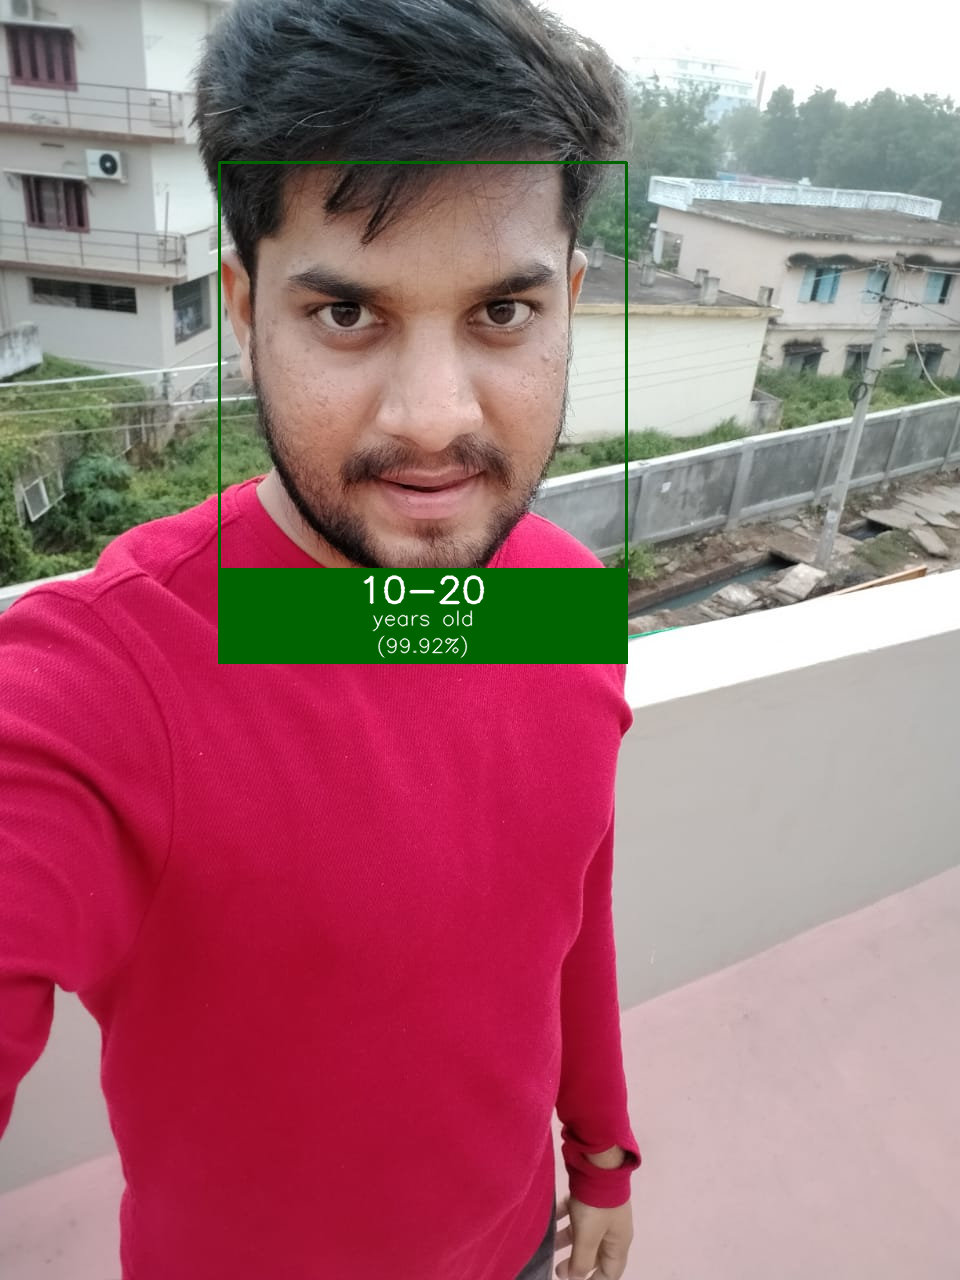

In [ ]:
# Reading the image from filepath provided above and passing it through the age clasification method defined above.
from google.colab.patches import cv2_imshow

img = cv2.imread(my_image)
age_img = classify_age(img)

# Saving the new generated image with a new name at the same location. 
try:
    new_my_image = new_img_name(my_image)
    cv2.imwrite(new_my_image, age_img)
    print(f"Saved to {new_my_image}")
except:
    print("Error: Could not save image!")

cv2_imshow(age_img)
cv2.waitKey(0);

### Age Detection on Live Webcam Video

In [ ]:
# Accessing the webcam and passing the video frames through the age clasification method defined above.

# Creating a VideoCapture object.
cap = cv2.VideoCapture(0)

# Checking if camera opened successfully.
if (cap.isOpened() == False): 
    print("Unable to read camera feed!")

# Getting the video frame width and height.
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))

# Defining the codec and creating a VideoWriter object to save the output video in the current working directory.
fourcc = cv2.VideoWriter_fourcc(*'MP4V')
cur_time = datetime.fromtimestamp(time.time()).strftime('%Y%m%d%H%M%S')
out = cv2.VideoWriter(f"Webcam_{cur_time}_WITH_AGE.mp4", fourcc, 18, (frame_width, frame_height))

while(cap.isOpened()):
    
    # Grabbing each individual frame, frame-by-frame.
    ret, frame = cap.read()
    
    if ret==True:
        
        # Running age detection on the grabbed frame.
        age_img = classify_age(frame)
        
        # Saving frame to output video using the VideoWriter object defined above.
        out.write(age_img)

        # Displaying the frame with age detected.
        cv2_imshow("Age Detection on Live Video", age_img)
        
        # Exiting if "Q" key is pressed on the keyboard.
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    else:
        break

# Releasing the VideoCapture and VideoWriter objects, and closing the displayed frame.
cap.release()
out.release()
cv2.destroyAllWindows()
print(f"Saved to Webcam_{cur_time}_WITH_AGE.mp4")

Unable to read camera feed!
Saved to Webcam_20201229034224_WITH_AGE.mp4


### Age Detection on a Video File

In [ ]:
# Provide the video filepath as a string below

my_video = "/content/drive/MyDrive/20201222_165208_09.mp4"

In [ ]:
# Reading the video from filepath provided above and passing it through the age clasification method defined above.

# Creating a VideoCapture object.
cap = cv2.VideoCapture(my_video)

# Checking if video can be accessed successfully.
if (cap.isOpened() == False): 
    print("Unable to read video!")

# Getting the video frame width and height.
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))

# Defining the codec and creating a VideoWriter object to save the output video at the same location.
fourcc = cv2.VideoWriter_fourcc(*'MP4V')
new_my_video = new_vid_name(my_video)
out = cv2.VideoWriter(new_my_video, fourcc, 18, (frame_width, frame_height))

while(cap.isOpened()):
    
    # Grabbing each individual frame, frame-by-frame.
    ret, frame = cap.read()
    
    if ret==True:
        
        # Running age detection on the grabbed frame.
        age_img = classify_age(frame)
        
        # Saving frame to output video using the VideoWriter object defined above.
        out.write(age_img)
        
        # Displaying the frame with age detected.
        cv2_imshow(age_img)
        
        # Exiting if "Q" key is pressed on the keyboard.
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    else:
        break

# Releasing the VideoCapture and VideoWriter objects, and closing the displayed frame.
cap.release()
out.release()
cv2.destroyAllWindows()

NameError: ignored